In [533]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.metrics import make_scorer, mean_squared_error, accuracy_score, classification_report, precision_recall_curve, auc, roc_auc_score, roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from tqdm import tqdm
from ydata_profiling import ProfileReport
from lightgbm import LGBMClassifier
from xgboost import plot_importance

In [534]:
syn_df= pd.read_csv('train.csv')
original_df = pd.read_csv('cirrhosis.csv')

In [535]:
test_df = pd.read_csv('test.csv')

In [536]:
df = pd.concat([syn_df,original_df], axis = 0)

In [537]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8323 entries, 0 to 417
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   float64
 1   N_Days         8323 non-null   int64  
 2   Drug           8217 non-null   object 
 3   Age            8323 non-null   int64  
 4   Sex            8323 non-null   object 
 5   Ascites        8217 non-null   object 
 6   Hepatomegaly   8217 non-null   object 
 7   Spiders        8217 non-null   object 
 8   Edema          8323 non-null   object 
 9   Bilirubin      8323 non-null   float64
 10  Cholesterol    8189 non-null   float64
 11  Albumin        8323 non-null   float64
 12  Copper         8215 non-null   float64
 13  Alk_Phos       8217 non-null   float64
 14  SGOT           8217 non-null   float64
 15  Tryglicerides  8187 non-null   float64
 16  Platelets      8312 non-null   float64
 17  Prothrombin    8321 non-null   float64
 18  Stage         

In [538]:
nan_counts = df.isna().sum()
print(df.shape)
print(nan_counts)

(8323, 21)
id                418
N_Days              0
Drug              106
Age                 0
Sex                 0
Ascites           106
Hepatomegaly      106
Spiders           106
Edema               0
Bilirubin           0
Cholesterol       134
Albumin             0
Copper            108
Alk_Phos          106
SGOT              106
Tryglicerides     136
Platelets          11
Prothrombin         2
Stage               6
Status              0
ID               7905
dtype: int64


/tmp/ipykernel_188373/4242082661.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette=palette)


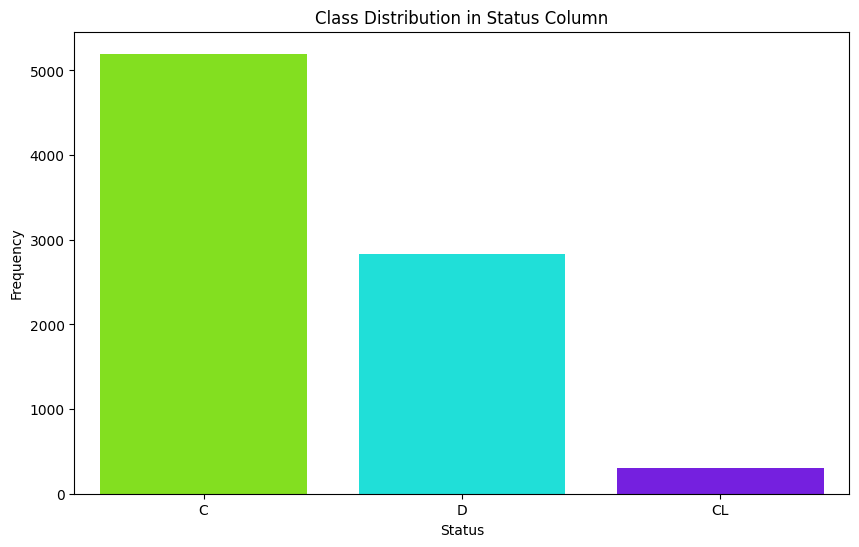

In [539]:
# Count the occurrences of each class in the 'Status' column
status_counts = df['Status'].value_counts()

# Create a color palette with a distinct color for each class
palette = sns.color_palette("hsv", 3)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=status_counts.index, y=status_counts.values, palette=palette)
plt.title('Class Distribution in Status Column')
plt.xlabel('Status')
plt.ylabel('Frequency')
plt.show()

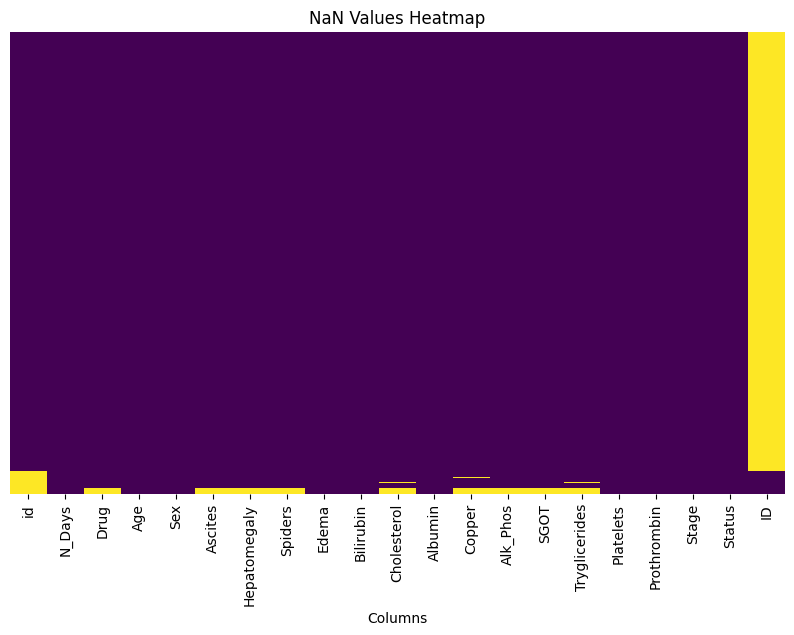

In [540]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('NaN Values Heatmap')
plt.xlabel('Columns')
plt.show()

In [541]:
df.drop(['ID'],axis=1, inplace = True)

In [542]:
df.head(10)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0.0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1.0,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2.0,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3.0,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4.0,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
5,5.0,703,D-penicillamine,19270,F,N,Y,N,N,0.6,227.0,3.46,34.0,6456.2,60.63,68.0,213.0,11.5,3.0,D
6,6.0,1300,Placebo,17703,F,N,N,N,N,1.0,328.0,3.35,43.0,1677.0,137.95,90.0,291.0,9.8,3.0,C
7,7.0,1615,Placebo,21281,F,N,Y,N,N,0.6,273.0,3.94,36.0,598.0,52.70,214.0,227.0,9.9,3.0,C
8,8.0,2050,D-penicillamine,20684,F,N,N,N,N,0.7,360.0,3.65,72.0,3196.0,94.55,154.0,269.0,9.8,2.0,C
9,9.0,2615,D-penicillamine,15009,F,N,N,N,N,0.9,478.0,3.60,39.0,1758.0,171.00,140.0,234.0,10.6,2.0,C


In [543]:
def count_outliers_iqr(df):
    outlier_counts = {}

    for col in df.select_dtypes(include=np.number).columns:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR

        lower_bound = Q1 - outlier_step
        upper_bound = Q3 + outlier_step

        outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        outlier_counts[col] = outlier_count

    return outlier_counts

# Apply the function to your dataframe
outliers_count = count_outliers_iqr(df)
print(outliers_count)


{'id': 0, 'N_Days': 0, 'Age': 37, 'Bilirubin': 846, 'Cholesterol': 0, 'Albumin': 198, 'Copper': 0, 'Alk_Phos': 0, 'SGOT': 0, 'Tryglicerides': 0, 'Platelets': 0, 'Prothrombin': 0, 'Stage': 0}


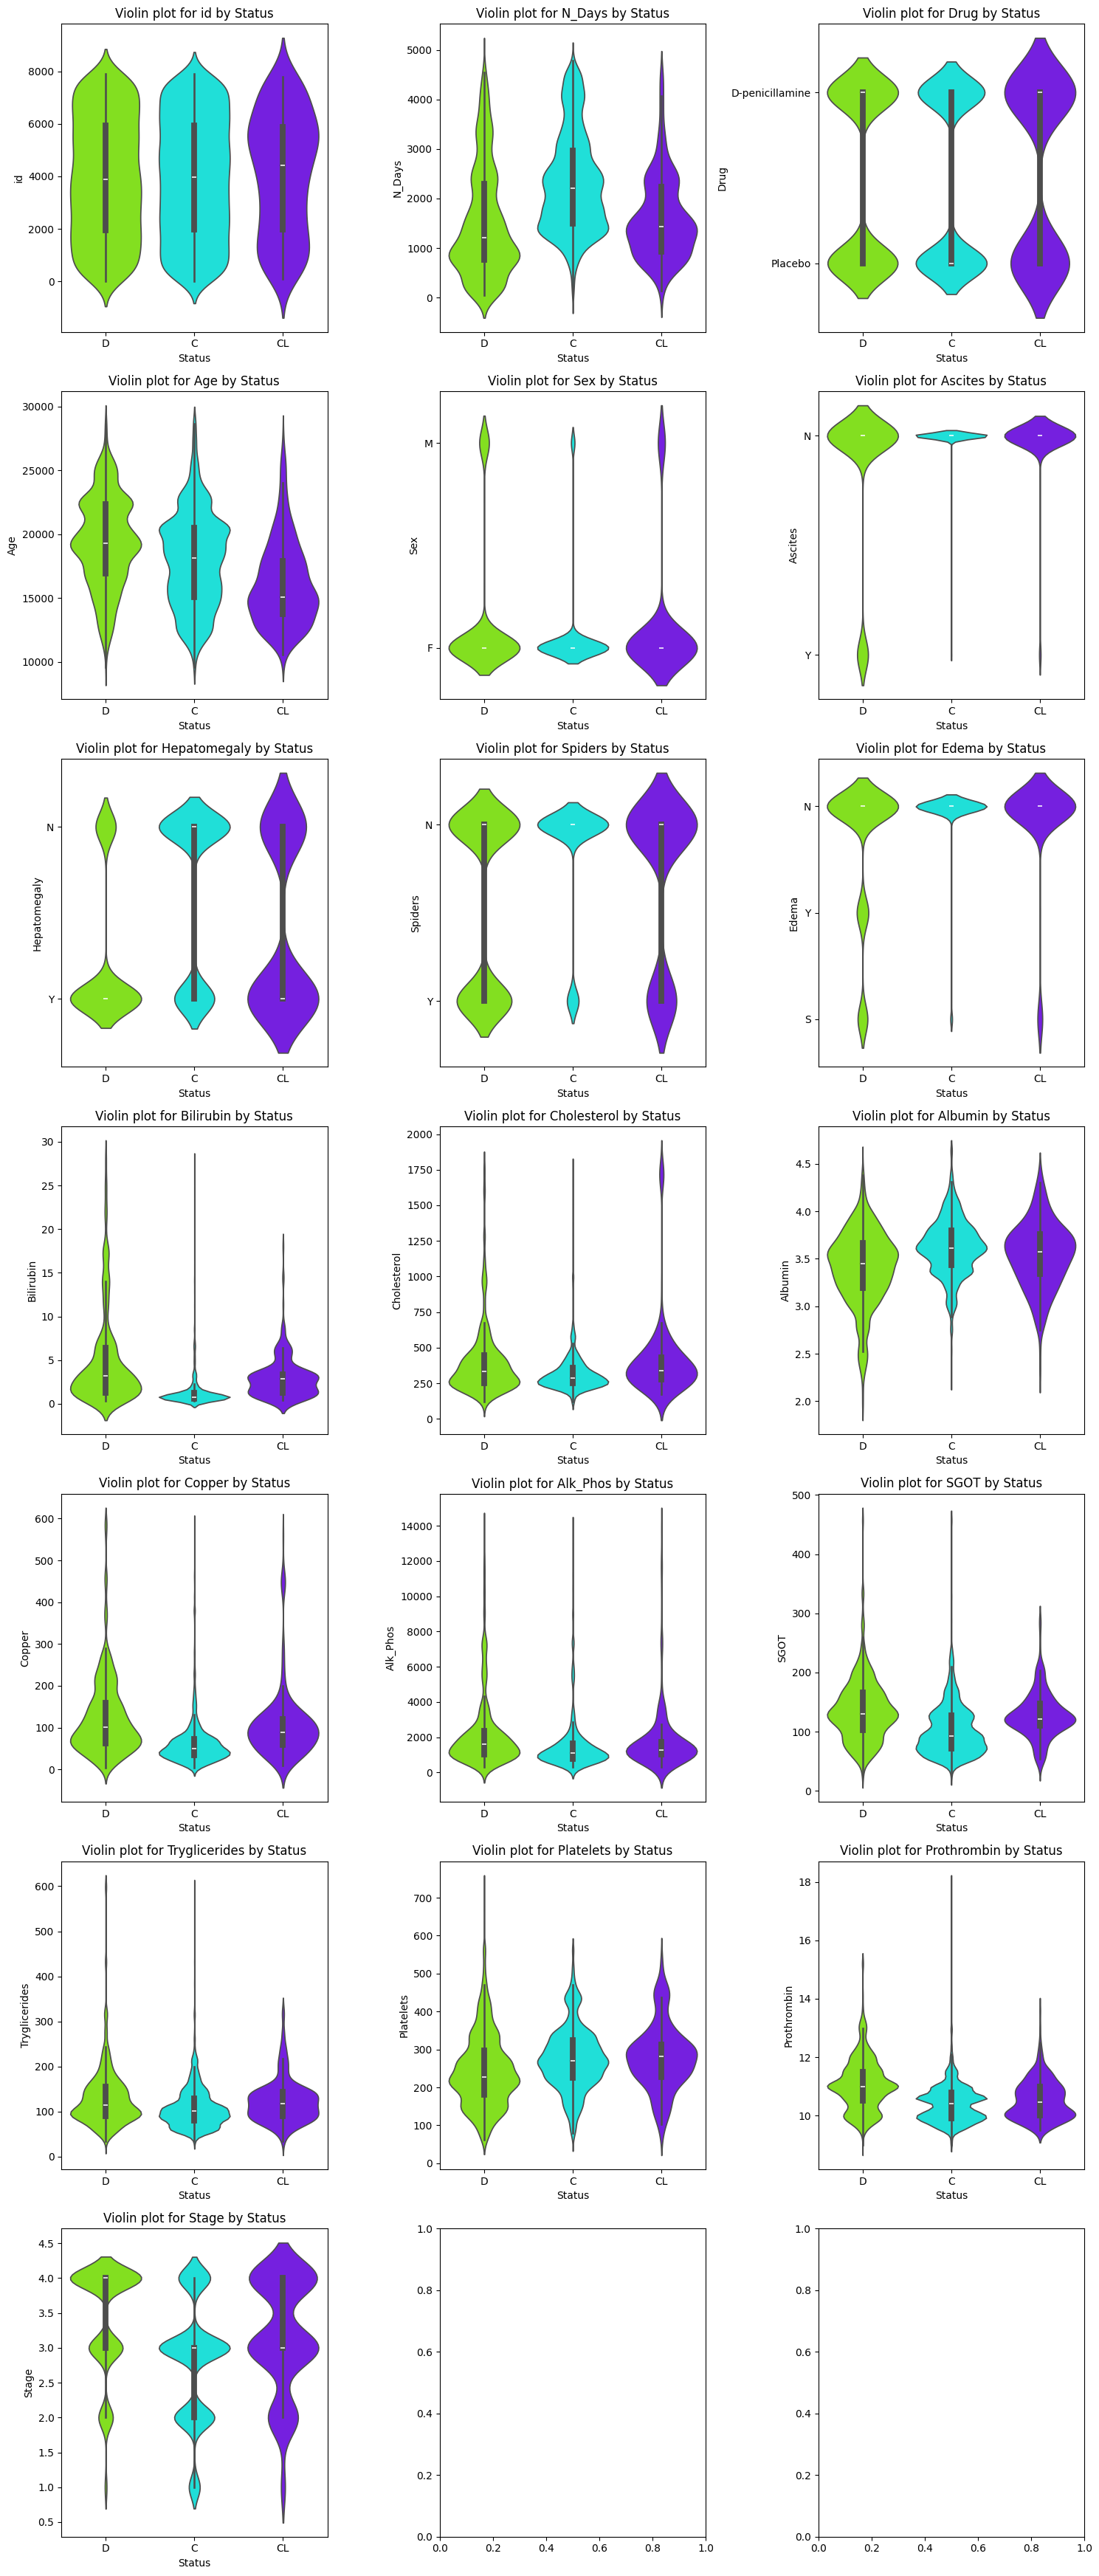

In [544]:
df = df.reset_index(drop=True)
# Define a color palette
palette = sns.color_palette("hsv", 3)

# Filter out the 'Status' column
features = [column for column in df.columns if column != 'Status']

# Number of plots per row
plots_per_row = 3

# Calculate the number of rows needed
num_rows = (len(features) + plots_per_row - 1) // plots_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 5 * num_rows))

for i, column in enumerate(features):
    row, col = divmod(i, plots_per_row)
    sns.violinplot(x='Status', y=column, hue='Status', data=df, palette=palette, ax=axes[row, col])
    axes[row, col].set_title(f'Violin plot for {column} by Status')

# Adjust layout
plt.tight_layout()
plt.show()

# Reference intervals
Time to make little research for find intervals online for each blood parameter

In [545]:
# Define reference intervals
reference_intervals = {
    "Bilirubin": (0.3, 1.2),
    "Cholesterol": (0, 200),
    "Albumin": (3.4, 5.4),
    "Copper": (70, 140),
    "Alk_Phos": (44, 147),
    "SGOT": (10, 40),
    "Tryglicerides": (0, 150),
    "Platelets": (150, 450),
    "Prothrombin": (11, 13.5)
}

# Function to check if value is within the interval
def is_normal(value, lower, upper):
    return int(lower <= value <= upper)

# Apply the function to each column
for feature, (lower, upper) in reference_intervals.items():
    df[f'{feature}_Normal'] = df[feature].apply(is_normal, args=(lower, upper))
for feature, (lower, upper) in reference_intervals.items():
    test_df[f'{feature}_Normal'] = test_df[feature].apply(is_normal, args=(lower, upper))


In [546]:
df.head(10)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,Status,Bilirubin_Normal,Cholesterol_Normal,Albumin_Normal,Copper_Normal,Alk_Phos_Normal,SGOT_Normal,Tryglicerides_Normal,Platelets_Normal,Prothrombin_Normal
0,0.0,999,D-penicillamine,21532,M,N,N,N,N,2.3,...,D,0,0,0,0,0,0,1,1,0
1,1.0,2574,Placebo,19237,F,N,N,N,N,0.9,...,C,1,0,1,0,0,0,1,1,1
2,2.0,3428,Placebo,13727,F,N,Y,Y,Y,3.3,...,D,0,0,1,1,0,0,1,1,1
3,3.0,2576,Placebo,18460,F,N,N,N,N,0.6,...,C,1,0,1,0,0,0,1,1,0
4,4.0,788,Placebo,16658,F,N,Y,N,N,1.1,...,C,1,0,1,0,0,0,1,1,0
5,5.0,703,D-penicillamine,19270,F,N,Y,N,N,0.6,...,D,1,0,1,0,0,0,1,1,1
6,6.0,1300,Placebo,17703,F,N,N,N,N,1.0,...,C,1,0,0,0,0,0,1,1,0
7,7.0,1615,Placebo,21281,F,N,Y,N,N,0.6,...,C,1,0,1,0,0,0,0,1,0
8,8.0,2050,D-penicillamine,20684,F,N,N,N,N,0.7,...,C,1,0,1,1,0,0,0,1,0
9,9.0,2615,D-penicillamine,15009,F,N,N,N,N,0.9,...,C,1,0,1,0,0,0,1,1,0


In [547]:
df.nunique()

id                      7905
N_Days                   495
Drug                       2
Age                      397
Sex                        2
Ascites                    2
Hepatomegaly               2
Spiders                    2
Edema                      3
Bilirubin                117
Cholesterol              227
Albumin                  167
Copper                   171
Alk_Phos                 364
SGOT                     206
Tryglicerides            154
Platelets                252
Prothrombin               50
Stage                      4
Status                     3
Bilirubin_Normal           2
Cholesterol_Normal         2
Albumin_Normal             2
Copper_Normal              2
Alk_Phos_Normal            1
SGOT_Normal                2
Tryglicerides_Normal       2
Platelets_Normal           2
Prothrombin_Normal         2
dtype: int64

In [548]:
df.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status', 'Bilirubin_Normal', 'Cholesterol_Normal',
       'Albumin_Normal', 'Copper_Normal', 'Alk_Phos_Normal', 'SGOT_Normal',
       'Tryglicerides_Normal', 'Platelets_Normal', 'Prothrombin_Normal'],
      dtype='object')

In [549]:
test_df.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Bilirubin_Normal', 'Cholesterol_Normal', 'Albumin_Normal',
       'Copper_Normal', 'Alk_Phos_Normal', 'SGOT_Normal',
       'Tryglicerides_Normal', 'Platelets_Normal', 'Prothrombin_Normal'],
      dtype='object')

In [550]:
def create_new_features(df):
    df['DiagnosisDays'] = df['Age'] - df['N_Days']
    df['Bilirubin_Albumin'] = df['Bilirubin'] * df['Albumin']
    df['Liver_Function_Score'] = (df['Bilirubin'] + df['Albumin'] + df['Alk_Phos'] + df['SGOT'] + df['Prothrombin']) / 5
    df['Risk_Score'] = df['Bilirubin'] + df['Albumin'] - df['Alk_Phos']
    df['Age_in_year'] = (df['Age'] / 365).astype(int)
    df['Age_Group'] = pd.cut(df['Age_in_year'], bins=[19, 29, 49, 64, 99], labels=[0, 1, 2, 3]).astype('int16')
    df['Symptom_Severity_Score'] = df['Ascites'] + df['Hepatomegaly'] + df['Spiders']
    df['Age_Bilirubin_Interaction'] = df['Age'] * df['Bilirubin']
    df['Diag_Year'] = (df['N_Days'] / 365).astype(int)
    df['Diag_Month'] = ((df['N_Days'] % 365) / 30).astype(int)
    return df

df = create_new_features(df)
test_df = create_new_features(test_df)

In [551]:
df.head()

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,...,DiagnosisDays,Bilirubin_Albumin,Liver_Function_Score,Risk_Score,Age_in_year,Age_Group,Symptom_Severity_Score,Age_Bilirubin_Interaction,Diag_Year,Diag_Month
0,0.0,999,D-penicillamine,21532,M,N,N,N,N,2.3,...,20533,7.705,359.230,-1595.35,58,2,NNN,49523.6,2,8
1,1.0,2574,Placebo,19237,F,N,N,N,N,0.9,...,16663,3.186,318.058,-1435.56,52,2,NNN,17313.3,7,0
2,2.0,3428,Placebo,13727,F,N,Y,Y,Y,3.3,...,10299,11.715,233.380,-1022.15,37,1,NYY,45299.1,9,4
3,3.0,2576,Placebo,18460,F,N,N,N,N,0.6,...,15884,2.100,347.820,-1648.90,50,2,NNN,11076.0,7,0
4,4.0,788,Placebo,16658,F,N,Y,N,N,1.1,...,15870,4.015,264.380,-1176.25,45,1,NYN,18323.8,2,1


In [552]:
from sklearn.preprocessing import LabelEncoder

# List of columns to be label encoded
columns_to_label_encode = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Status', 'Symptom_Severity_Score', 'Edema']
columns_to_label_encode_test = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Symptom_Severity_Score', 'Edema']

# Applying LabelEncoder to each column
for column in columns_to_label_encode:
    df[column] = LabelEncoder().fit_transform(df[column])
for column in columns_to_label_encode_test:
    test_df[column] = LabelEncoder().fit_transform(test_df[column])


In [553]:
df.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status', 'Bilirubin_Normal', 'Cholesterol_Normal',
       'Albumin_Normal', 'Copper_Normal', 'Alk_Phos_Normal', 'SGOT_Normal',
       'Tryglicerides_Normal', 'Platelets_Normal', 'Prothrombin_Normal',
       'DiagnosisDays', 'Bilirubin_Albumin', 'Liver_Function_Score',
       'Risk_Score', 'Age_in_year', 'Age_Group', 'Symptom_Severity_Score',
       'Age_Bilirubin_Interaction', 'Diag_Year', 'Diag_Month'],
      dtype='object')

In [554]:
test_df.columns

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Bilirubin_Normal', 'Cholesterol_Normal', 'Albumin_Normal',
       'Copper_Normal', 'Alk_Phos_Normal', 'SGOT_Normal',
       'Tryglicerides_Normal', 'Platelets_Normal', 'Prothrombin_Normal',
       'DiagnosisDays', 'Bilirubin_Albumin', 'Liver_Function_Score',
       'Risk_Score', 'Age_in_year', 'Age_Group', 'Symptom_Severity_Score',
       'Age_Bilirubin_Interaction', 'Diag_Year', 'Diag_Month'],
      dtype='object')

In [555]:
print(df.shape,test_df.shape)

(8323, 39) (5271, 38)


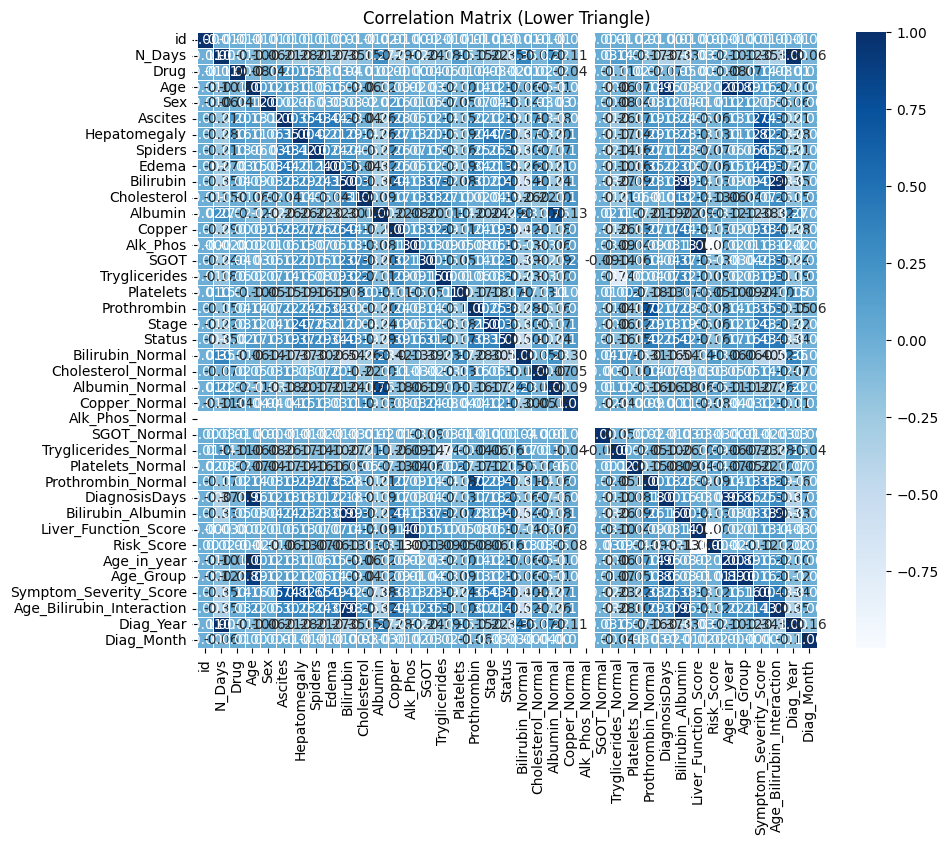

In [556]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix (Lower Triangle)')
plt.show()

To much features here to see which features are highly corelated, so below we will detect them with simple function.

In [557]:
threshold=0.9

def find_highly_correlated_columns(df, threshold):
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Find pairs of highly correlated features
    highly_corr_pairs = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i]
                highly_corr_pairs.add(colname)

    return list(highly_corr_pairs)

# Apply the function to your dataframe
columns_to_drop = find_highly_correlated_columns(df, threshold)
print("Columns to consider dropping:", columns_to_drop)


Columns to consider dropping: ['Bilirubin_Albumin', 'DiagnosisDays', 'Risk_Score', 'Diag_Year', 'Liver_Function_Score', 'Age_in_year', 'Age_Bilirubin_Interaction']


In [558]:
df.dropna(inplace=True)

In [559]:
print(df.shape,test_df.shape)

(7905, 39) (5271, 38)


# LGBM with BayesSearch for hyperpatameters 

Original class distribution: Counter({0: 3972, 2: 2132, 1: 220})
Resampled class distribution: Counter({0: 3972, 2: 2132, 1: 330})
--------------------------------------------------
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling

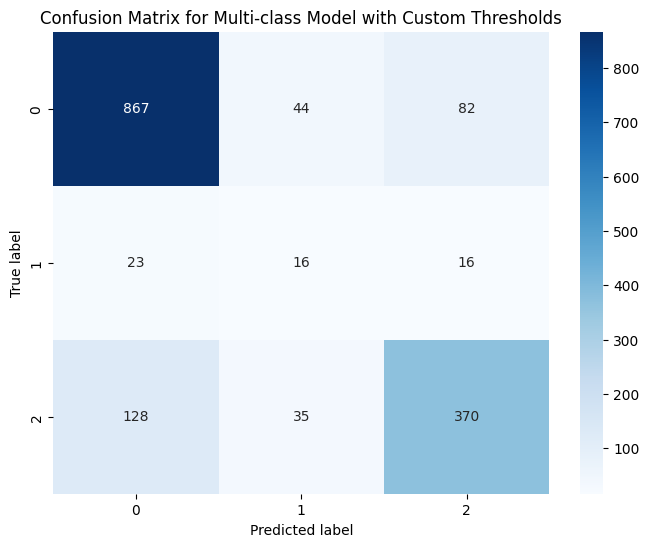

In [560]:
X = df.drop(['Status'], axis=1)
y = df['Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Original class distribution
print("Original class distribution:", Counter(y_train))

# Define the desired class distribution
threshold = 0.1
minority_class = 1
minority_count = Counter(y_train)[minority_class]
desired_count = minority_count + int(minority_count * 0.5)  # Increase by 50%

sampling_strategy = {minority_class: desired_count}

# Resampling method with SMOTE
resampling_method = SMOTE(sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train, y_train)

# New class distribution
print("Resampled class distribution:", Counter(y_train_resampled))
print('-'*50)
# Define the search space for hyperparameters
search_spaces = {
    'num_leaves': Integer(31, 150),
    'learning_rate': Real(0.01, 0.3),
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(3, 12),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.6, 0.9),
    'colsample_bytree': Real(0.6, 0.9),
    'reg_lambda': Real(0.0, 1.0),
    'scale_pos_weight': Real(1, 10)
}

# Bayesian search with LightGBM
bayes_search = BayesSearchCV(
    estimator=LGBMClassifier(verbose=-1),
    search_spaces=search_spaces,
    scoring='accuracy',
    n_iter=32,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit the Bayesian search
bayes_search.fit(X_train_resampled, y_train_resampled)

# Best model
best_model = bayes_search.best_estimator_

# Get probability scores for each class
y_probs = best_model.predict_proba(X_test)

# Define thresholds for each class
thresholds = [0.5, threshold, 0.5]  # Adjust as needed

# Apply the thresholds
y_probs_adjusted = np.array([y_probs[:, i] / thresholds[i] for i in range(len(thresholds))]).T

# Get predictions based on the highest probability score after applying the thresholds
y_pred_custom_threshold = np.argmax(y_probs_adjusted, axis=1)

# Evaluation with the new thresholds
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
report = classification_report(y_test, y_pred_custom_threshold)
conf_matrix = confusion_matrix(y_test, y_pred_custom_threshold)

# Display the results
print("Best Hyperparameters:", bayes_search.best_params_)
print("Accuracy with Custom Thresholds:", accuracy)
print("Classification Report with Custom Thresholds:\n", report)
print(conf_matrix)
# Compute and plot confusion matrix with custom thresholds
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Multi-class Model with Custom Thresholds')
plt.show()


Original class distribution: Counter({0: 3972, 2: 2132, 1: 220})
Resampled class distribution: Counter({0: 3972, 2: 2132, 1: 660})
--------------------------------------------------
Accuracy with Custom Thresholds: 0.7906388361796332
Classification Report with Custom Thresholds:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       993
           1       0.20      0.62      0.30        55
           2       0.83      0.68      0.75       533

    accuracy                           0.79      1581
   macro avg       0.63      0.72      0.64      1581
weighted avg       0.84      0.79      0.81      1581

[[852  74  67]
 [ 13  34   8]
 [104  65 364]]


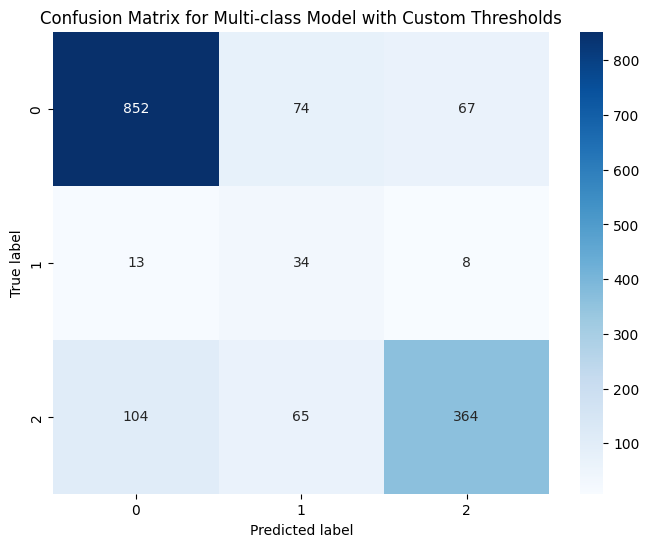

In [573]:
custom_threshold = 0.05
sampling = 2

# Assuming df is your DataFrame
X = df.drop(['Status'], axis=1)
y = df['Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Original class distribution
print("Original class distribution:", Counter(y_train))

# Define the desired class distribution
minority_class = 1
minority_count = Counter(y_train)[minority_class]
desired_count = minority_count + int(minority_count * sampling)  

sampling_strategy = {minority_class: desired_count}

# Resampling method with SMOTE
resampling_method = SMOTE(sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train, y_train)

# New class distribution
print("Resampled class distribution:", Counter(y_train_resampled))
print('-'*50)

# Best hyperparameters obtained from Bayesian search
best_hyperparams = {
    'colsample_bytree': 0.855402123712121,
    'learning_rate': 0.18704187592703472,
    'max_depth': 7,
    'min_child_weight': 6,
    'n_estimators': 71,
    'num_leaves': 134,
    'reg_lambda': 0.6568793492194994,
    'scale_pos_weight': 3.6318584931907916,
    'subsample': 0.821322806719583
}

# Create and fit the model with the best hyperparameters
best_model = LGBMClassifier(**best_hyperparams, verbose=-1)
best_model.fit(X_train_resampled, y_train_resampled)

# Get probability scores for each class
y_probs = best_model.predict_proba(X_test)

# Define thresholds for each class
thresholds = [0.5, custom_threshold, 0.5]  # Adjust as needed

# Apply the thresholds
y_probs_adjusted = np.array([y_probs[:, i] / thresholds[i] for i in range(len(thresholds))]).T

# Get predictions based on the highest probability score after applying the thresholds
y_pred_custom_threshold = np.argmax(y_probs_adjusted, axis=1)

# Evaluation with the new thresholds
accuracy = accuracy_score(y_test, y_pred_custom_threshold)
report = classification_report(y_test, y_pred_custom_threshold)
conf_matrix = confusion_matrix(y_test, y_pred_custom_threshold)

# Display the results
print("Accuracy with Custom Thresholds:", accuracy)
print("Classification Report with Custom Thresholds:\n", report)
print(conf_matrix)

# Compute and plot confusion matrix with custom thresholds
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Multi-class Model with Custom Thresholds')
plt.show()


# Tuning sampling_values and threshold_values

In [572]:
X = df.drop(['Status'], axis=1)
y = df['Status']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Define ranges for sampling and custom_threshold for the second class
sampling_values = [1.0, 1.5, 2]  # Example values
threshold_values = [0.05, 0.1, 0.15, 0.2]  # Example values for second class

# Best hyperparameters obtained from Bayesian search
best_hyperparams = {
    'colsample_bytree': 0.855402123712121,
    'learning_rate': 0.18704187592703472,
    'max_depth': 7,
    'min_child_weight': 6,
    'n_estimators': 71,
    'num_leaves': 134,
    'reg_lambda': 0.6568793492194994,
    'scale_pos_weight': 3.6318584931907916,
    'subsample': 0.821322806719583
}

for sampling in sampling_values:
    for custom_threshold in threshold_values:
        
        # Resampling
        # Define the desired class distribution
        minority_class = 1
        minority_count = Counter(y_train)[minority_class]
        desired_count = minority_count + int(minority_count * sampling)

        sampling_strategy = {minority_class: desired_count}
        resampling_method = SMOTE(sampling_strategy=sampling_strategy)
        X_train_resampled, y_train_resampled = resampling_method.fit_resample(X_train, y_train)

        # Training
        best_model = LGBMClassifier(**best_hyperparams, verbose=-1)
        best_model.fit(X_train_resampled, y_train_resampled)

        # Predicting
        y_probs = best_model.predict_proba(X_test)

        # Apply the custom threshold for the second class
        thresholds = [0.5, custom_threshold, 0.5]
        y_probs_adjusted = np.array([y_probs[:, i] / thresholds[i] for i in range(len(thresholds))]).T
        y_pred_custom_threshold = np.argmax(y_probs_adjusted, axis=1)
        
        report = classification_report(y_test, y_pred_custom_threshold)
        conf_matrix = confusion_matrix(y_test, y_pred_custom_threshold)
        
        print(f"Sampling: {sampling}, Threshold: {custom_threshold}")
        print("Confusion Matrix:")
        print(conf_matrix)
        print(report)
        print('-'*50)


Sampling: 1.0, Threshold: 0.05
Confusion Matrix:
[[857  58  78]
 [ 17  26  12]
 [123  57 353]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       993
           1       0.18      0.47      0.27        55
           2       0.80      0.66      0.72       533

    accuracy                           0.78      1581
   macro avg       0.61      0.67      0.62      1581
weighted avg       0.81      0.78      0.79      1581

--------------------------------------------------
Sampling: 1.0, Threshold: 0.1
Confusion Matrix:
[[885  31  77]
 [ 22  21  12]
 [128  30 375]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       993
           1       0.26      0.38      0.31        55
           2       0.81      0.70      0.75       533

    accuracy                           0.81      1581
   macro avg       0.64      0.66      0.64      1581
weighted avg       0.82      0.81      0.81      1581

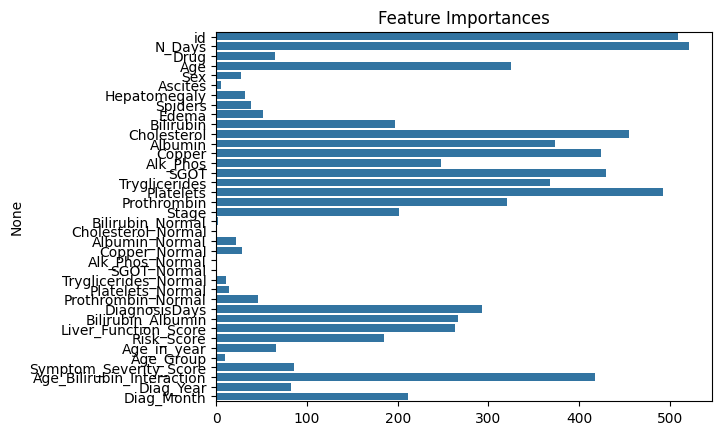

In [563]:
# Plotting feature importance after the last run
feature_importances = best_model.feature_importances_
sns.barplot(x=feature_importances, y=X.columns)
plt.title('Feature Importances')
plt.show()

# Submission part

In [564]:
y_pred_test = best_model.predict_proba(test_df)
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.columns = ['Status_C', 'Status_CL','Status_D']
y_pred_test.head()

,Status_C,Status_CL,Status_D
0,0.611438,0.007082,0.381481
1,0.657705,0.226626,0.115668
2,0.008840,0.007533,0.983627
3,0.862038,0.002103,0.135860
4,0.932397,0.018454,0.049150


In [565]:
submission_df = pd.DataFrame()
submission_df = y_pred_test  
submission_df['id'] = test_df['id']
submission_df['id'] = submission_df['id'].apply(lambda x : int(x))
submission_df.head()

,Status_C,Status_CL,Status_D,id
0,0.611438,0.007082,0.381481,7905
1,0.657705,0.226626,0.115668,7906
2,0.008840,0.007533,0.983627,7907
3,0.862038,0.002103,0.135860,7908
4,0.932397,0.018454,0.049150,7909


In [566]:
submission_df.to_csv('submission.csv', index= False)